In [17]:
import numpy as np
import matplotlib.pyplot as plt

from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.decomposition.asf import ASF
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import VelocityReward, ManipulabilityReward, ZRRReward, MinForceReward, MinManipulabilityReward,DexterityIndexReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward, ActuatedMassReward, TrajectoryIMFReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT, jps_graph2pinocchio_robot_3d_constraints
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
import pinocchio as pin
pin.seed(2)

In [18]:
MECH_FROM_OPTIMIZATION = False
WEIGHT = 0.5

In [19]:
if MECH_FROM_OPTIMIZATION:
    import tkinter as tk
    from tkinter import filedialog

    def select_directory():
        # Create a root window
        root = tk.Tk()
        # Hide the root window
        root.withdraw()
        # Make the root window the topmost window
        root.call('wm', 'attributes', '.', '-topmost', True)
        # Open directory dialog and store the selected directory path
        directory_path = filedialog.askdirectory(initialdir="./",
            title="Select a directory"
        )
        root.update_idletasks() 
        root.destroy()
        # Check if a directory was selected
        if directory_path:
            #print(f"Selected directory: {directory_path}")
            return directory_path
        else:
            #print("No directory selected")
            return None

    # Call the function to open the directory dialog
    selected_directory = select_directory()
    print(f"Resulting directory path: {selected_directory}")


    problem = MultiCriteriaProblem.load(
        selected_directory
    )

    checkpoint = load_checkpoint(selected_directory)
    optimizer = PymooOptimizer(problem, checkpoint)
    optimizer.load_history(selected_directory)
    res = optimizer.run()

    F = res.F
    fl = F.min(axis=0)
    fu = F.max(axis=0)

    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    weights = np.array([WEIGHT, 1-WEIGHT])

    decomp = ASF()
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]

    graph = problem.graph_manager.get_graph(best_x)
    draw_joint_point(graph)
    initial_x = best_x

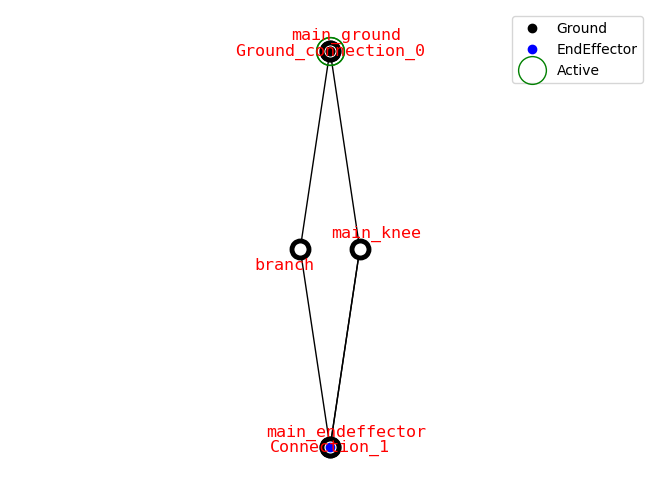

In [20]:
from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint
if not MECH_FROM_OPTIMIZATION:
    tp = TopologyManager2D()
    # creates ground connection
    tp.add_connection(ground=True, self_mutation_range= [(-0.2001, 0.1999),None,(-0.1, 0.1)], dependent_mutation_range=[(-0.13,0.07),None,(-0.3,-0.1)])
    main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
    tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
    main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_knee', attach_ground=False, attach_endeffector=False)
    tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
    # creates connection on the first link
    tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
    main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
    tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))
    # creates connection on the second link
    tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.5, 0.3)], self_freeze_pos=[0.0,0,-0.4999], dependent_mutation_range=[(-0.2,0.0),None,(-0.0,0.2)])
    # creates branch node and one-joint branch in the topology manager. 
    branch_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=False, name='branch', attach_ground=False, attach_endeffector=False)
    tp.add_relative_node(branch_jp)
    # adds a dependent connection of the one-joint branch to the 
    tp.add_dependent_connection(0,1,connect_head=True)
    # adds independent connection to the second link finishing the branch building
    tp.add_independent_connection(tp.branch_ends[1][1],tp.connections[2].connection_jp)
    tp.set_mutation_ranges()
    tp.visualize()
    graph = tp.graph
    initial_x = tp.generate_central_from_mutation_range()

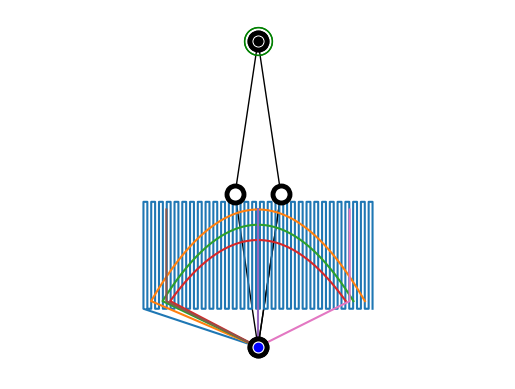

In [21]:
from auto_robot_design.utils.configs import get_standard_builder, get_standard_crag, get_standard_trajectories, get_standard_rewards, get_mesh_builder
builder = get_standard_builder()
crag = get_standard_crag(open_loop=False)
trajectories = get_standard_trajectories()
rewards = get_standard_rewards()


for _, trajectory in trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

draw_joint_point(graph, draw_labels=False)
plt.show()

In [22]:
if MECH_FROM_OPTIMIZATION:
    gm = problem.graph_manager
    mr = gm.mutation_ranges
    print(gm.mutation_ranges)
else:
    mr  = tp.mutation_ranges
    print(tp.mutation_ranges)

{'Ground_connection_0_0': (-0.2001, 0.1999), 'Ground_connection_0_2': (-0.1, 0.1), 'main_knee_2': (-0.30000000000000004, -0.1), 'branch_0': (-0.13, 0.07), 'branch_2': (-0.3, -0.1)}


(-0.30000000000000004, -0.1)


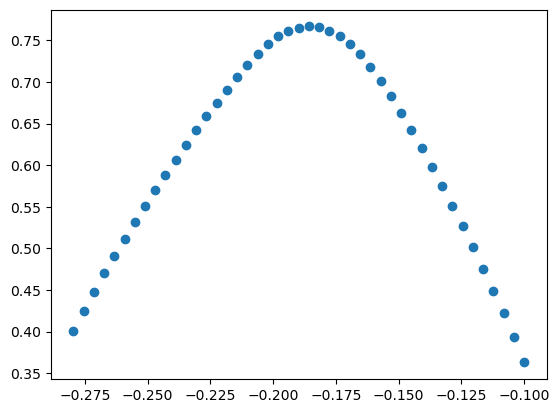

Number of invalid points: 5


In [29]:
trajectory_name = 'step1'
reward_name = 'dexterity'
trajectory = trajectories[trajectory_name]
reward_class = rewards[reward_name]
error_calculator = PositioningErrorCalculator(jacobian_key="Manip_Jacobian")
soft_constraint = PositioningConstrain(error_calculator=error_calculator, points=[trajectory])
range_idx = 2
range = mr[list(mr.keys())[range_idx]]
print(range)
values = np.linspace(range[0],range[1],num=50,endpoint=True)
x = initial_x.copy()
reward_values = []
valid_points=[]
counter = 0
for value in values:
    x[range_idx] = value
    if MECH_FROM_OPTIMIZATION:
        graph = gm.get_graph(x)
    else:
        graph = tp.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder=builder)
    constrain_error, results = soft_constraint.calculate_constrain_error(crag, fixed_robot, free_robot)
    if constrain_error == 0:
        reward, reward_list = rewards[reward_name].calculate(results[0][0], results[0][1], results[0][2], Actuator = builder.actuator['default'])
        reward_values.append(reward)
        valid_points.append(value)
        
    else:
        counter+=1

plt.scatter(valid_points, reward_values)
plt.show()
print(f"Number of invalid points: {counter}")

In [27]:
results[0]

({'IMF': array([0.06887475, 0.06623051, 0.06382249, 0.06161239, 0.05958096,
        0.05771167, 0.05599214, 0.05440553, 0.05294315, 0.05159524,
        0.05035215, 0.04920791, 0.04815475, 0.0471864 , 0.04629718,
        0.04548194, 0.04473599, 0.04405505, 0.04343521, 0.04287289,
        0.04236321, 0.04190638, 0.04149801, 0.04113552, 0.04081658,
        0.04053899, 0.04030077, 0.04010005, 0.03993515, 0.03980413,
        0.03970635, 0.03964002, 0.03960395, 0.039597  , 0.03961815,
        0.03966648, 0.03974116, 0.03984137, 0.03996646, 0.04011582,
        0.0402889 , 0.04048525, 0.04070445, 0.04094616, 0.04121012,
        0.04149611, 0.04180283, 0.0421323 , 0.04248349, 0.0428564 ,
        0.04325112, 0.04366775, 0.04410648, 0.04456754, 0.04504867,
        0.04555506, 0.04608475, 0.04663819, 0.04721586, 0.04781829,
        0.04844607, 0.04909984, 0.04978029, 0.05048814, 0.05122105,
        0.05198594, 0.05278073, 0.05360635, 0.05446377, 0.05535401,
        0.05627812, 0.05723723, 0.058232

In [ ]:
from pinocchio.visualize import MeshcatVisualizer
import meshcat
counter = 0
suspicious_points = []
for value in values:
    x[range_idx] = value
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
    constrain_error
    if constrain_error == 0:
        counter+=1
        if counter==1 or counter==2:
            # viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
            # viz.viewer = meshcat.Visualizer().open()
            # viz.clean()
            # viz.loadViewerModel()
            # draw_joint_point(graph)
            # plt.show()
            suspicious_points.append(value)
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        print(value)
        reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
        reward_values.append(reward)
        valid_points.append(value)
        
    else:
        print(value, constrain_error)

-0.2
-0.18620689655172415
-0.1724137931034483
-0.15862068965517243
-0.14482758620689656
-0.13103448275862067
-0.11724137931034483
-0.10344827586206896
-0.0896551724137931
-0.07586206896551724
-0.062068965517241365
-0.0482758620689655
-0.03448275862068964
-0.02068965517241378
-0.006896551724137917
0.006896551724137945
0.020689655172413807
0.03448275862068967
0.04827586206896553
0.06206896551724139
0.07586206896551728
0.08965517241379312
0.103448275862069
0.11724137931034484
0.13103448275862073
0.14482758620689656
0.15862068965517245
0.1724137931034483
0.18620689655172418
0.2


In [ ]:
x[range_idx] = suspicious_points[1]
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory, viz=viz)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
